In [1]:
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,70).__str__()
import cv2 # import after setting OPENCV_IO_MAX_IMAGE_PIXELS
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np

In [6]:
def plot_image(image_1, image_2,title_1="Orignal",title_2="New Image"):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    plt.title(title_1)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    plt.title(title_2)
    plt.show()

# U-net Multiclass

In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
     
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    #Expansive path
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
     
    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model
 

2022-10-29 16:55:05.882863: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [10]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [11]:
#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#training image as a list
train_images = []

for directory_path in glob.glob("unet_multi_data/train_images/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
     
train_images = np.array(train_images)

#training mask/label as a list
train_masks = [] 
for directory_path in glob.glob("unet_multi_data/train_masks/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


In [12]:
np.unique(train_masks)

array([ 29,  76, 149], dtype=uint8)

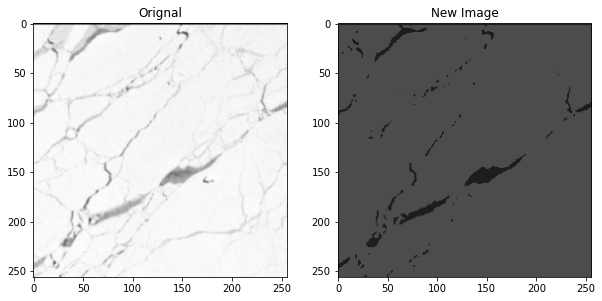

In [13]:
plot_image(train_images[1], train_masks[1])

In [14]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)


/home/iqrah/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [15]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2])

In [16]:
train_images.shape

(4032, 256, 256)

In [17]:
train_masks.shape

(4032, 256, 256)

In [18]:
#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [19]:
train_images.shape

(4032, 256, 256, 1)

In [20]:
train_masks_input.shape

(4032, 256, 256, 1)

In [21]:
#Selecting 20% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)


In [22]:


print("Class values in the dataset are ... ", np.unique(y_train))



Class values in the dataset are ...  [0 1 2]


In [23]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [24]:
train_masks_cat.shape

(3225, 256, 256, 3)

In [26]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-10-29 16:56:41.508849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 16:56:42.107160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13807 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:b3:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_transpose_2 (Conv2DTran  (None, 64, 64, 64)  32832       ['conv2d_15[0][0]']              
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 64, 64, 128)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'conv2d_5[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 64)   73792       ['concatenate_2[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 64, 64, 64)   0           ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_17

In [27]:
import time

t0 = time.time()
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 

                    shuffle=False)
t1 = time.time()

total = t1-t0
print("time is ", total)

Epoch 1/50


2022-10-17 17:55:36.248200: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


202/202 [==============================] - 32s 124ms/step - loss: 0.5455 - accuracy: 0.7703 - val_loss: 0.4299 - val_accuracy: 0.8324
Epoch 2/50
202/202 [==============================] - 22s 108ms/step - loss: 0.3872 - accuracy: 0.8576 - val_loss: 0.3788 - val_accuracy: 0.8661
Epoch 3/50
202/202 [==============================] - 22s 109ms/step - loss: 0.3615 - accuracy: 0.8676 - val_loss: 0.3614 - val_accuracy: 0.8709
Epoch 4/50
202/202 [==============================] - 22s 109ms/step - loss: 0.3494 - accuracy: 0.8683 - val_loss: 0.3666 - val_accuracy: 0.8682
Epoch 5/50
202/202 [==============================] - 22s 109ms/step - loss: 0.3362 - accuracy: 0.8727 - val_loss: 0.3499 - val_accuracy: 0.8750
Epoch 6/50
202/202 [==============================] - 22s 109ms/step - loss: 0.3836 - accuracy: 0.8644 - val_loss: 0.3496 - val_accuracy: 0.8744
Epoch 7/50
202/202 [==============================] - 22s 109ms/step - loss: 0.3110 - accuracy: 0.8797 - val_loss: 0.3738 - val_accuracy: 0.8

In [28]:
model.save('s2_multi_with_cloud_50.hdf5')

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


26/26 [==============================] - 3s 64ms/step - loss: 0.2076 - accuracy: 0.9196
Accuracy is =  91.96350574493408 %


In [27]:
#model = get_model()

model.load_weights('s2_multi_with_cloud_50.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

2022-10-29 16:57:26.002997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


26/26 [==============================] - 5s 74ms/step


In [28]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

acc

26/26 [==============================] - 2s 65ms/step - loss: 0.1859 - accuracy: 0.9349
Accuracy is =  93.49379539489746 %


0.9349379539489746

In [29]:
###
#plot the training and validation accuracy and loss at each epoch
"""
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
"""

NameError: name 'history' is not defined

In [29]:

#model = get_model()

model.load_weights('s2_multi_with_cloud_50.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

26/26 [==============================] - 1s 55ms/step


In [30]:
##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8380018


[[9.0506980e+06 2.0289590e+06 1.3629900e+05]
 [7.0376500e+05 1.6777216e+07 3.9400000e+02]
 [4.7957700e+05 9.1970000e+04 9.1543460e+06]]
IoU for class1 is:  0.7299363
IoU for class2 is:  0.8558799
IoU for class3 is:  0.9281892


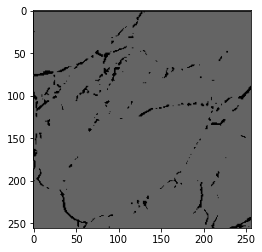

In [31]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])
#class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
#print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')


1/1 [==============================] - 0s 431ms/step


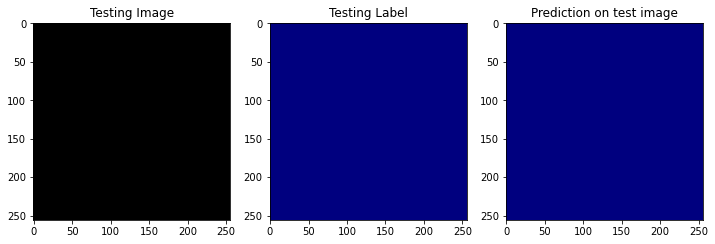

In [32]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()


mask shape  [0 1]
1/1 [==============================] - 0s 281ms/step
[0 1 2]


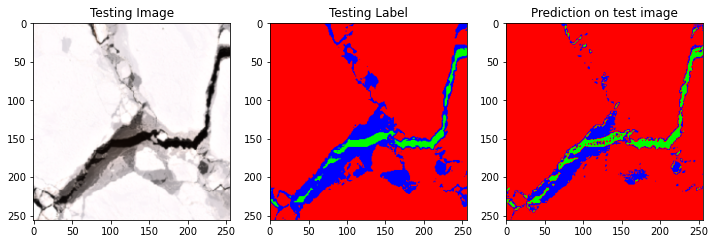

In [34]:
root_image = "unet_multi_data/val_ori/"
root_mask = "unet_multi_data/train_masks/"
img = cv2.imread(root_image + "s2_vis_06_0256_1280.png")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(root_mask + "s2_seg_06_0256_1280.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask.shape
mask_reshaped = mask.reshape(-1,1)
mask_reshaped_encoded = labelencoder.fit_transform(mask_reshaped)
mask_encoded_original_shape = mask_reshaped_encoded.reshape(n, h, w)
print("mask shape ",np.unique(mask_encoded_original_shape))

test_img_norm=img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

print(np.unique(predicted_img))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(mask,cmap="jet")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap="brg")
plt.show()



## Validation

## More than 10% cloud and shadow cover

In [35]:
#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_shadow/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
      
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

array([ 29,  76, 149], dtype=uint8)

In [36]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2])

In [37]:
val_images.shape

(128, 256, 256)

In [38]:
val_masks.shape

(128, 256, 256)

In [39]:
#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

In [40]:
val_images.shape

(128, 256, 256, 1)

In [41]:
val_masks_input.shape

(128, 256, 256, 1)

In [42]:
## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))


In [43]:
val_masks_cat.shape

(128, 256, 256, 3)

In [44]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


4/4 [==============================] - 0s 69ms/step - loss: 0.2534 - accuracy: 0.8874
Accuracy is =  88.74267339706421 %


In [45]:
#ori data

import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()
    '''
    
    
    #print(unet_fp[i])
    

1/1 [==============================] - 0s 30ms/step


In [46]:
len(label)

8388608

In [47]:
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

6549837 1088296 750475


In [48]:
import tensorflow as tf
tf.math.confusion_matrix(label, pred)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1000943,   77081,   10272],
       [ 798431, 5751404,       2],
       [  56723,    1823,  691929]], dtype=int32)>

In [49]:
#########################################################333333333333
#------------->> refined

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_ref/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
     
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

val_images.shape

val_masks.shape

#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

val_images.shape

val_masks_input.shape

## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))

val_masks_cat.shape

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


#ori data

#######################################################################
#root = "unet_multi_data/val_new_mask/"
#root_val = "unet_multi_data/unet_res_ori/"
#unet_fp = []
#for fp in sorted(os.listdir(root)):
#    if fp.split(".")[-1].lower() in {"png"}:
#        unet_fp.append(root_val+fp)
            

import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()

'''
#brg = 0,1,2
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

#ice = label.count(2)
#tice = label.count(1)
#water = label.count(0)
#print(ice, tice, water)
tf.math.confusion_matrix(label, pred)


4/4 [==============================] - 0s 72ms/step - loss: 0.0398 - accuracy: 0.9891
Accuracy is =  98.9112377166748 %
1/1 [==============================] - 0s 27ms/step
6549837 1088296 750475


<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1073545,   14144,     607],
       [  59986, 6489851,       0],
       [  16595,       0,  733880]], dtype=int32)>

In [50]:
#########################################################333333333333
#------------->> shadow free

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_shadow_free/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
#Convert list to array for machine learning processing        
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_free_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

val_images.shape

val_masks.shape

#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

val_images.shape

val_masks_input.shape

## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))

val_masks_cat.shape

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


#ori data

#######################################################################
#root = "unet_multi_data/val_new_mask/"
#root_val = "unet_multi_data/unet_res_ori/"
#unet_fp = []
#for fp in sorted(os.listdir(root)):
#    if fp.split(".")[-1].lower() in {"png"}:
#        unet_fp.append(root_val+fp)
            

import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()
    '''
#brg = 0,1,2
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

#ice = label.count(2)
#tice = label.count(1)
#water = label.count(0)
#print(ice, tice, water)
tf.math.confusion_matrix(label, pred)




12/12 [==============================] - 1s 68ms/step - loss: 0.1891 - accuracy: 0.9227
Accuracy is =  92.26694107055664 %
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step
10669520 9070277 5426027


<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 7368612,  1624115,    77550],
       [   97381, 10572139,        0],
       [  144750,     2291,  5278986]], dtype=int32)>

In [51]:
array = tf.math.confusion_matrix(label, pred).numpy()
print(array)

[[ 7368612  1624115    77550]
 [   97381 10572139        0]
 [  144750     2291  5278986]]


## Less than 10% cloud and shadow cover

In [52]:
#########################################################333333333333
#------------->> shadow free ref

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_shadow_free_ref/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
#Convert list to array for machine learning processing        
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_free_ref_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

val_images.shape

val_masks.shape

#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

val_images.shape

val_masks_input.shape

## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))

val_masks_cat.shape

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


#ori data

#######################################################################
#root = "unet_multi_data/val_new_mask/"
#root_val = "unet_multi_data/unet_res_ori/"
#unet_fp = []
#for fp in sorted(os.listdir(root)):
#    if fp.split(".")[-1].lower() in {"png"}:
#        unet_fp.append(root_val+fp)
            

import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()
    '''
#brg = 0,1,2
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

#ice = label.count(2)
#tice = label.count(1)
#water = label.count(0)
#print(ice, tice, water)
tf.math.confusion_matrix(label, pred)




12/12 [==============================] - 1s 69ms/step - loss: 0.0499 - accuracy: 0.9823
Accuracy is =  98.23357462882996 %
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 43ms/step
16019602 3729438 5416784


<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 3661526,    65684,     2228],
       [  305624, 15713840,      138],
       [   70861,        0,  5345923]], dtype=int32)>

# Confusion Matrix

## Confusion Matrix Cloudy and Shadowy

Thin Ice      1088296
Thick Ice     6549837
Open water     750475
dtype: int64


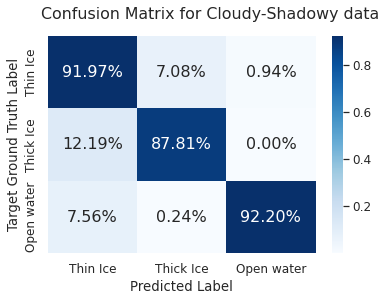

In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# 1st row water ground truth
# 2nd row thin ice ground truth
# 3rd row thick ice ground truth

array =[[1000943,   77081,   10272],
       [ 798431, 5751404,       2],
       [  56723,    1823,  691929]]

#array = [[ 956127,  127567,    4602],
#        [ 557494, 5992343,       0],
#        [  64385,    1873,  684217]]

df_cm = pd.DataFrame(array, range(3), range(3))
#plt.figure(figsize=(5,3))
a = ["Thin Ice", "Thick Ice", "Open water"]
df_cm = pd.DataFrame(array, index = [i for i in a],
              columns = [i for i in a])

#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
#            fmt='.2%', cmap='Blues')
df_cm_sum = df_cm.sum(axis = 1)
print(df_cm_sum)
sn.set(font_scale=1.1) # for label size

df_cm['Thin Ice'] = df_cm['Thin Ice']/df_cm_sum
df_cm['Thick Ice'] = df_cm['Thick Ice']/df_cm_sum
df_cm['Open water'] = df_cm['Open water']/df_cm_sum

#print(df_cm['Open water'])

sn.heatmap(df_cm, annot=True, fmt='.2%', annot_kws={"size": 16}, cmap="Blues") # font size

plt.xlabel("Predicted Label")
plt.ylabel("Target Ground Truth Label")

plt.suptitle("Confusion Matrix for Cloudy-Shadowy data")
plt.show()

Thin Ice      1088296
Thick Ice     6549837
Open water     750475
dtype: int64


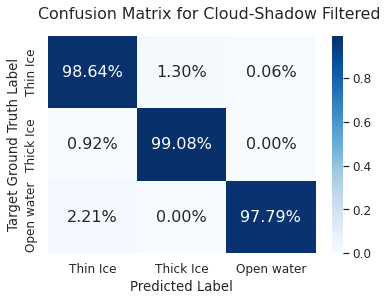

In [58]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# 1st row water ground truth
# 2nd row thin ice ground truth
# 3rd row thick ice ground truth


#array =[[1000943,   77081,   10272],
#       [ 798431, 5751404,       2],
#       [  56723,    1823,  691929]]

array = [[1073545,   14144,     607],
        [  59986, 6489851,       0],
        [  16595,       0,  733880]]

df_cm = pd.DataFrame(array, range(3), range(3))
#plt.figure(figsize=(5,3))
a = ["Thin Ice", "Thick Ice", "Open water"]
df_cm = pd.DataFrame(array, index = [i for i in a],
              columns = [i for i in a])

#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
#            fmt='.2%', cmap='Blues')
df_cm_sum = df_cm.sum(axis = 1)
print(df_cm_sum)
sn.set(font_scale=1.1) # for label size
df_cm['Thin Ice'] = df_cm['Thin Ice']/df_cm_sum
df_cm['Thick Ice'] = df_cm['Thick Ice']/df_cm_sum
df_cm['Open water'] = df_cm['Open water']/df_cm_sum

#print(df_cm['Open water'])

sn.heatmap(df_cm, annot=True, fmt='.2%', annot_kws={"size": 16}, cmap="Blues") # font size

plt.xlabel("Predicted Label")
plt.ylabel("Target Ground Truth Label")

plt.suptitle("Confusion Matrix for Cloud-Shadow Filtered")
plt.show()